## **Exploratory Data Analysis**

Before introducing any model, we conducted an exploratory data analysis to clean and better understand our dataset.
 
The dataset used in this project was obtained from Kaggle and is available at the following link:     
[Multilingual Customer Support Tickets](https://www.kaggle.com/datasets/tobiasbueck/multilingual-customer-support-tickets?select=dataset-tickets-multi-lang3-4k.csv)   
 
It contains a collection of real-world customer support tickets written in english or german, along with metadata such as ticket subject, body, language, assigned queue, priority, and various tags.    
 
We chose this dataset because it offers rich information (dataset size: 20k records) that allows us to classify the appropriate queue for each support ticket based on the given details. By analyzing the info given, we aim to predict which team or department (queue) should handle the ticket.     
 
This classification task can help to automatize the assignment process in customer support systems, ensuring that each ticket is directed to the right team for a timely and effective response.

### Import Libraries

In [1]:
import sys
sys.path.append('..')
import os
import csv

In [2]:
# Data science libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.probability import FreqDist
from collections import Counter

# Custom libraries
from src.data_exploration_utils import *

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/elenamartineztorrijos/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/elenamartineztorrijos/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/elenamartineztorrijos/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Dataset

In [3]:
# Read the CSV file into a DataFrame
df_tickets_initial = pd.read_csv('../data/dataset-tickets-multi-lang-4-20k.csv')
df_tickets_initial.head()

,subject,body,answer,type,queue,priority,language,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8
0,Unvorhergesehener Absturz der Datenanalyse-Pla...,Die Datenanalyse-Plattform brach unerwartet ab...,Ich werde Ihnen bei der Lösung des Problems he...,Incident,General Inquiry,low,de,Crash,Technical,Bug,Hardware,Resolution,Outage,Documentation,NaN
1,Customer Support Inquiry,Seeking information on digital strategies that...,We offer a variety of digital strategies and s...,Request,Customer Service,medium,en,Feedback,Sales,IT,Tech Support,NaN,NaN,NaN,NaN
2,Data Analytics for Investment,I am contacting you to request information on ...,I am here to assist you with data analytics to...,Request,Customer Service,medium,en,Technical,Product,Guidance,Documentation,Performance,Feature,NaN,NaN
3,Krankenhaus-Dienstleistung-Problem,Ein Medien-Daten-Sperrverhalten trat aufgrund ...,Zurück zur E-Mail-Beschwerde über den Sperrver...,Incident,Customer Service,high,de,Security,Breach,Login,Maintenance,Incident,Resolution,Feedback,NaN
4,Security,"Dear Customer Support, I am reaching out to in...","Dear [name], we take the security of medical d...",Request,Customer Service,medium,en,Security,Customer,Compliance,Breach,Documentation,Guidance,NaN,NaN


In [4]:
df_tickets_initial.shape

(20000, 15)

We can appreciate that the dataset contains the next variables:
- `subject`: Subject of the customer's email.
- `body`: Body of the customer's email.
- `answer`: The response provided by the helpdesk agent.
- `type`: The type of ticket as picked by the agent (Incident, Request, Problem, Change).
- `queue`: Specifies the department to which the email ticket is routed (General Inquiry, Customer Service, Technical Support, IT Support, Product Support, Billing and Payments, Service Outages and Maintenance, Human Resources, Returns and Exchanges, Sales and Pre-Sales). 
- `priority`: Indicates the urgency and importance of the issue (low, medium, high).
- `language`: Indicates the language in which the email is written (de, en).
- `tag`: Tags/categories assigned to the ticket to further classify and identify common issues or topics, split into ten columns in the dataset (examples: "Product Support," "Technical Support," "Sales Inquiry").

##### Selection of variables

To predict the appropriate support ticket `queue`, we kept only the most relevant information. We retained the `subject` and `body` of the customer message and the `language` field, which is essential for distinguishing the language during model training.    

We excluded the `answer` field because it is provided after the queue is assigned, as well as the `type`, `priority`, and `tag_1` to `tag_8` fields due to their inconsistency or unreliability at ticket submission.     

In summary, we use only the customer's message (`subject` and `body`) and `language` to ensure a simple, fair, and effective model.

In [5]:
df_tickets_filtered = df_tickets_initial[['subject', 'body', 'language', 'queue']].copy()
df_tickets_filtered.head()

,subject,body,language,queue
0,Unvorhergesehener Absturz der Datenanalyse-Pla...,Die Datenanalyse-Plattform brach unerwartet ab...,de,General Inquiry
1,Customer Support Inquiry,Seeking information on digital strategies that...,en,Customer Service
2,Data Analytics for Investment,I am contacting you to request information on ...,en,Customer Service
3,Krankenhaus-Dienstleistung-Problem,Ein Medien-Daten-Sperrverhalten trat aufgrund ...,de,Customer Service
4,Security,"Dear Customer Support, I am reaching out to in...",en,Customer Service


##### Check for duplicates

In [6]:
duplicate_count = df_tickets_filtered.duplicated().sum()
print(f"Number of duplicate records: {duplicate_count}")

Number of duplicate records: 0


##### Check datatypes and missing values

In [7]:
df_tickets_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   subject   18539 non-null  object
 1   body      19998 non-null  object
 2   language  20000 non-null  object
 3   queue     20000 non-null  object
dtypes: object(4)
memory usage: 625.1+ KB


We observed 18,539 missing values for subject and 19,998 for body.      

Since having data in either field is useful, we will concatenate `subject` and `body` into a single variable called `text`, and only remove records where both fields are missing.

In [8]:
nan_in_both = df_tickets_filtered[ df_tickets_filtered['body'].isna() & df_tickets_filtered['subject'].isna() ].shape[0]
print(f"Number of records with NaN in both 'body' and 'subject': {nan_in_both}")

Number of records with NaN in both 'body' and 'subject': 0


In [9]:
df_tickets = df_tickets_filtered.copy()
df_tickets['text'] = df_tickets['subject'].fillna('') + " " + df_tickets['body'].fillna('')
df_tickets = df_tickets.drop(columns=['subject', 'body'])
df_tickets.head()

,language,queue,text
0,de,General Inquiry,Unvorhergesehener Absturz der Datenanalyse-Pla...
1,en,Customer Service,Customer Support Inquiry Seeking information o...
2,en,Customer Service,Data Analytics for Investment I am contacting ...
3,de,Customer Service,Krankenhaus-Dienstleistung-Problem Ein Medien-...
4,en,Customer Service,"Security Dear Customer Support, I am reaching ..."


In [10]:
df_tickets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   language  20000 non-null  object
 1   queue     20000 non-null  object
 2   text      20000 non-null  object
dtypes: object(3)
memory usage: 468.9+ KB


All variables are of type object, which is appropriate since they all contain strings.    
 
Additionally, no missing values are present.

##### Analyze class imbalance

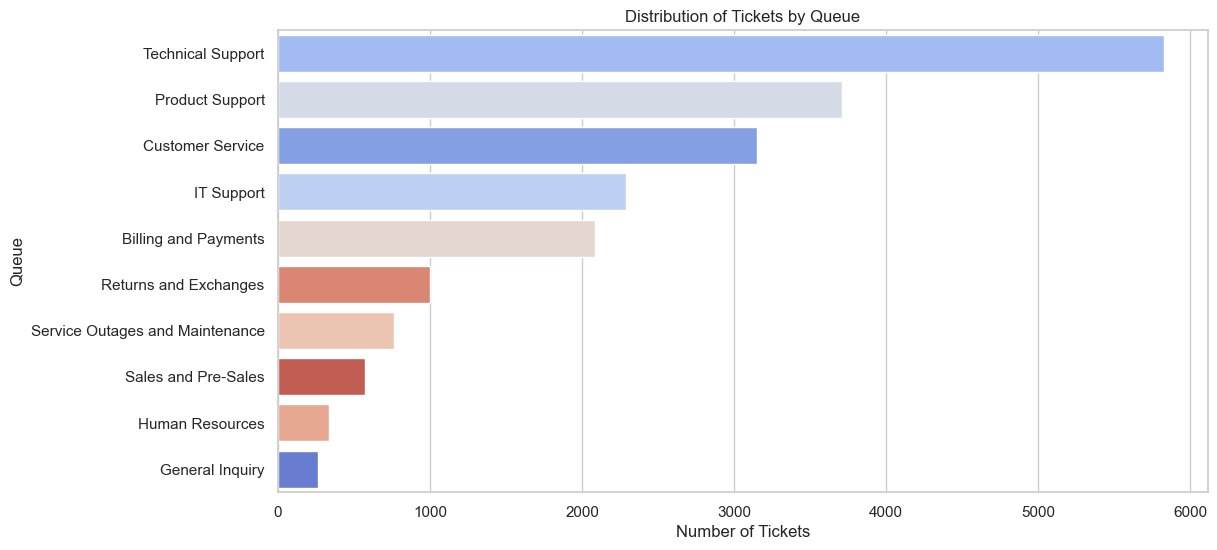

In [11]:
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.countplot(y=df_tickets['queue'], order=df_tickets['queue'].value_counts().index, palette="coolwarm", hue=df_tickets['queue'])
plt.title("Distribution of Tickets by Queue")
plt.xlabel("Number of Tickets")
plt.ylabel("Queue")
plt.show()

In [12]:
check_class_imbalance(df_tickets, 'queue')

,Counts,Percentage
queue,,
Technical Support,5824,29.12
Product Support,3708,18.54
Customer Service,3152,15.76
IT Support,2292,11.46
Billing and Payments,2086,10.43
Returns and Exchanges,1001,5.00
Service Outages and Maintenance,764,3.82
Sales and Pre-Sales,572,2.86
Human Resources,338,1.69


As we can observe, there is a clear class imbalance. Since discarding records from the majority class would result in the loss of valuable information and augmenting the minority class is not ideal, we opt to adjust the weights in the loss function so that the model pays more attention to the minority classes without altering the original data distribution.

### Text Preprocessing

In NLP context, text preprocessing is a crucial step before feeding the data into any machine learning or deep learning model. Raw text data is complex, and models need the text to be clean and structured to better understand the information.

With the function `preprocess_text` we intend to achieve clean text by following several steps:

- Normalization: Converts all characters to lowercase.
- Expand Contractions: Expands contractions (e.g., "can't" to "cannot") for better understanding.
- Remove Noise: Eliminates irrelevant characters that do not add value.
- Tokenization: Splits the text into individual words or tokens.
- Remove Stopwords: Removes common words that don’t contribute much semantic value.
- Lemmatization: Reduces words to their base or root form for better analysis.
- Remove Short Tokens: Removes irrelevant words (such as "a", "I", "on") that may be considered noise.

In [13]:
# Apply preprocessing function to the dataset
df_tickets['clean_text'] = df_tickets.apply(
    lambda row: preprocess_text(row['text'], row['language']), axis=1
)

In [14]:
df_tickets[['text', 'clean_text']].head()

,text,clean_text
0,Unvorhergesehener Absturz der Datenanalyse-Pla...,unvorhergesehener absturz datenanalyseplattfor...
1,Customer Support Inquiry Seeking information o...,customer support inquiry seeking information d...
2,Data Analytics for Investment I am contacting ...,data analytics investment contacting request i...
3,Krankenhaus-Dienstleistung-Problem Ein Medien-...,krankenhausdienstleistungproblem mediendatensp...
4,"Security Dear Customer Support, I am reaching ...",security dear customer support reaching inquir...


In [15]:
df_tickets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   language    20000 non-null  object
 1   queue       20000 non-null  object
 2   text        20000 non-null  object
 3   clean_text  20000 non-null  object
dtypes: object(4)
memory usage: 625.1+ KB


#### Frequency Distribution

In [16]:
all_tokens = []

# Iterate through each cleaned text and tokenize it
for text in df_tickets['clean_text']:
    all_tokens.extend(nltk.word_tokenize(text))


In [17]:
# Create a frequency distribution
fdist = FreqDist(all_tokens)

print(fdist.most_common(10))

[('data', 12976), ('issue', 11292), ('problem', 11127), ('support', 7695), ('could', 7282), ('would', 7090), ('system', 5762), ('the', 5672), ('integration', 5567), ('software', 5378)]


In [18]:
# 30 most common words
common_words = fdist.most_common(10)

common_words_df = pd.DataFrame(common_words, columns=['Word', 'Frequency'])

/var/folders/7t/tvwq6m6j5x379hykhkpqfxwh0000gn/T/ipykernel_77748/2824571354.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='Word', x='Frequency', data=common_words_df, palette="coolwarm")


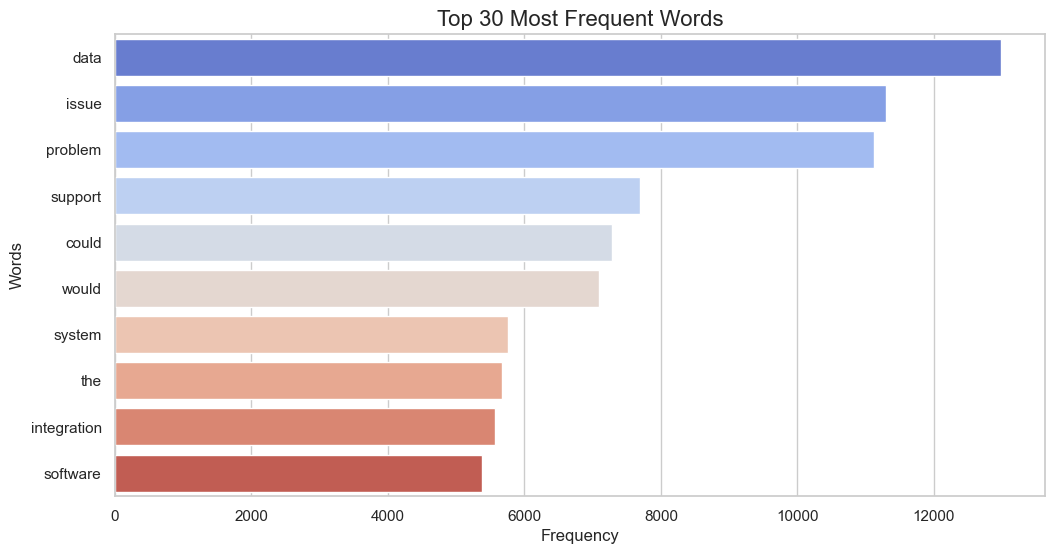

In [19]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.barplot(y='Word', x='Frequency', data=common_words_df, palette="coolwarm")
plt.title("Top 30 Most Frequent Words", fontsize=16)
plt.xlabel("Frequency", fontsize=12)
plt.ylabel("Words", fontsize=12)

plt.show()

In [20]:
word_counts = Counter(all_tokens)
word_counts_df = pd.DataFrame(word_counts.items(), columns=["Word", "Frequency"])

num_unique_words = len(word_counts)
print(f"Number of different words in the dataset: {num_unique_words}")

Number of different words in the dataset: 22510


In [21]:
# Frequency thresholds
word_counts_aux = pd.DataFrame({"frequency": [10, 7, 5, 3, 2]})

# Calculate the number of words with a frequency lower than each threshold
word_counts_aux["number_of_words"] = word_counts_aux["frequency"].apply(
    lambda x: (word_counts_df["Frequency"] < x).sum()
)

# Display the result
print(word_counts_aux)


   frequency  number_of_words
0         10            18274
1          7            17410
2          5            16415
3          3            14035
4          2            10973


This table suggests that the dataset is highly sparse, with many words appearing only a few times:

- 18,274 words appear fewer than 10 times.
- 17,410 words appear fewer than 7 times.
- 16,415 words appear fewer than 5 times.
- 14,035 words appear fewer than 3 times.
- 10,973 words appear fewer than 2 times.

Such low-frequency words are typically considered noise in text preprocessing. They are often domain-specific terms, misspellings, or irrelevant data that can introduce unnecessary complexity to the model and hinder the identification of meaningful patterns. 

To remove this, we have chosen to set a threshold of 3 occurrences, removing these rare words. This approach helps reduce noise, preserving the most important features.

#### Text Length Distribution

In [22]:
# Calculate text length (number of characters) for each text entry
df_tickets['text_length'] = df_tickets['clean_text'].apply(len)

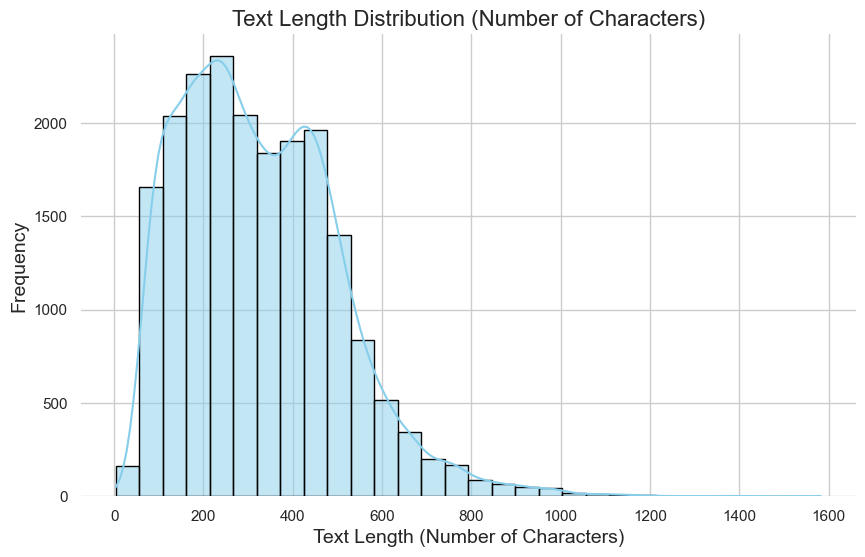

In [23]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(df_tickets['text_length'], bins=30, kde=True, color='skyblue', edgecolor='black')
plt.title('Text Length Distribution (Number of Characters)', fontsize=16)
plt.xlabel('Text Length (Number of Characters)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
sns.despine(left=True, bottom=True)
plt.show()

In [24]:
# Calculate the number of words in each text entry
df_tickets['word_count'] = df_tickets['clean_text'].apply(lambda x: len(x.split()))

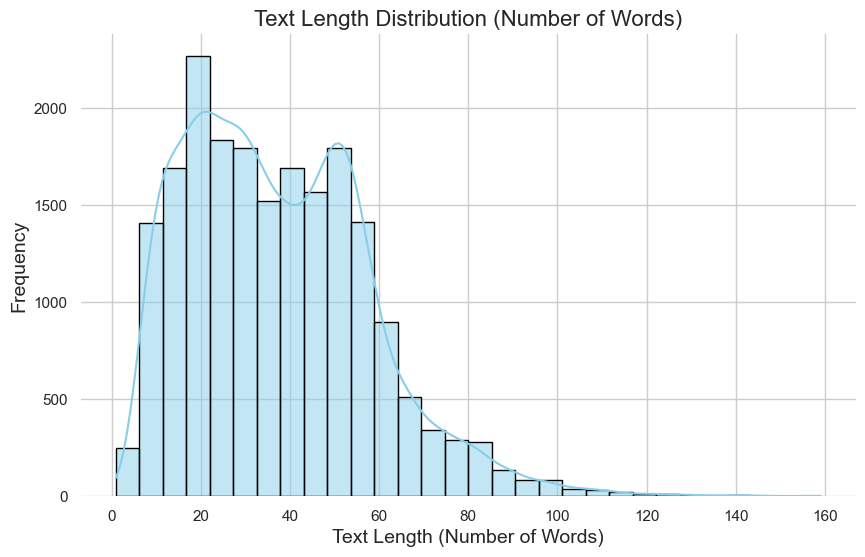

In [25]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(df_tickets['word_count'], bins=30, kde=True, color='skyblue', edgecolor='black')
plt.title('Text Length Distribution (Number of Words)', fontsize=16)
plt.xlabel('Text Length (Number of Words)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
sns.despine(left=True, bottom=True)
plt.show()


In [26]:
df_tickets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   language     20000 non-null  object
 1   queue        20000 non-null  object
 2   text         20000 non-null  object
 3   clean_text   20000 non-null  object
 4   text_length  20000 non-null  int64 
 5   word_count   20000 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 937.6+ KB


In [27]:
df_tickets[['clean_text', 'text_length', 'word_count']].head()

,clean_text,text_length,word_count
0,unvorhergesehener absturz datenanalyseplattfor...,206,20
1,customer support inquiry seeking information d...,179,24
2,data analytics investment contacting request i...,534,63
3,krankenhausdienstleistungproblem mediendatensp...,206,18
4,security dear customer support reaching inquir...,467,59


In [28]:
# Sort by word_count in ascending order (shortest texts first)
df_shortest_texts = df_tickets[['clean_text', 'text_length', 'word_count']].sort_values(by='word_count', ascending=True)

df_shortest_texts.head()

,clean_text,text_length,word_count
12193,assist,6,1
549,help,4,1
1821,probleme softwareintegration,28,2
17543,aktualisieren marketingkampagnen,32,2
4145,support needed,14,2


In [29]:
# Filter rows where the word_count is less than 3
short_texts = df_tickets[df_tickets['word_count'] < 3]
num_short_texts = short_texts.shape[0]
print(f"Number of records with less than 3 words: {num_short_texts}")

Number of records with less than 3 words: 6


As we can see, there are only a few cases where the word count is really small. These cases are unlikely to provide valuable insights for assigning the correct team, so we will exclude them from the analysis.

In [30]:
# Drop rows where the word_count is less than 3
df_filtered = df_tickets[df_tickets['word_count'] >= 3]
num_short_texts = df_tickets.shape[0] - df_filtered.shape[0]
df_tickets = df_filtered

print(f"Number of records with less than 3 words: {num_short_texts}")

df_tickets.head()

Number of records with less than 3 words: 6


,language,queue,text,clean_text,text_length,word_count
0,de,General Inquiry,Unvorhergesehener Absturz der Datenanalyse-Pla...,unvorhergesehener absturz datenanalyseplattfor...,206,20
1,en,Customer Service,Customer Support Inquiry Seeking information o...,customer support inquiry seeking information d...,179,24
2,en,Customer Service,Data Analytics for Investment I am contacting ...,data analytics investment contacting request i...,534,63
3,de,Customer Service,Krankenhaus-Dienstleistung-Problem Ein Medien-...,krankenhausdienstleistungproblem mediendatensp...,206,18
4,en,Customer Service,"Security Dear Customer Support, I am reaching ...",security dear customer support reaching inquir...,467,59


#### Save CSV

Finally, we export the cleaned data from `df_tickets` into a new .csv file for future use.

In [31]:
df_filtered.to_csv(
    path_or_buf=os.path.join("../data", "dataset_filtered_tickets.csv"),
    sep=";", 
    quoting=csv.QUOTE_ALL, 
    index=False
)

print("Filtered DataFrame has been saved as 'dataset_filtered_tickets.csv'.")


Filtered DataFrame has been saved as 'dataset_filtered_tickets.csv'.


### Word Cloud

Analyzing the most common words in our dataset can provide a quick snapshot of the dominant themes. In this case, we'll use a word cloud—a widely adopted visualization in NLP—to display words with sizes proportional to their occurrence.

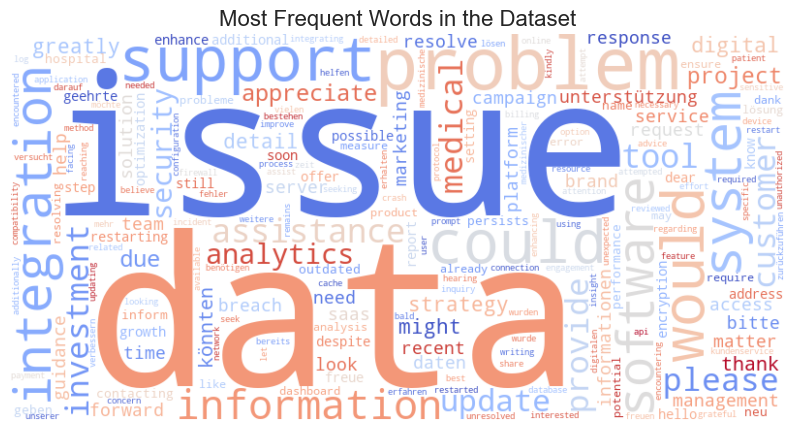

In [45]:
generate_wordcloud(df_tickets, stopwords=stop_words_en)

As expected, and aligning with the frequency distribution analysis, the two most frequent words are `issue` and `data`. 